In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   matera
   2   gorizia
   3   taranto
   4   bari
   5   arezzo
   6   fermo
   7   viterbo
   8   verbania
   9   monza
   10   massa
   11   grosseto
   12   livorno
   13   cagliari
   14   trento
   15   asti
   16   perugia
   17   savona
   18   potenza
   19   lucca
   20   palermo
   21   torino
   22   campobasso
   23   como
   24   lecco
   25   oristano
   26   pescara
   27   terni
   28   reggio_nell_emilia
   29   milano
   30   alessandria
   31   salerno
   32   pisa
   33   cuneo
   34   enna
   35   mantova
   36   varese
   37   frosinone
   38   pesaro
   39   brindisi
   40   avellino
   41   siracusa
   42   rieti
   43   ravenna
   44   reggio_di_calabria
   45   caserta
   46   rimini
   47   cremona
   48   belluno
   49   cosenza
   50   siena
   51   messina
   52   isernia
   53   padova
   54   teramo
   55   macerata
   56   genova
   57   carbonia
   58   imperia
   59   napo

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 matera
2 gorizia
3 taranto
4 bari
5 arezzo
6 fermo
7 viterbo
8 verbania
9 monza
10 massa
11 grosseto
12 livorno
13 cagliari
14 trento
15 asti
16 perugia
17 savona
18 potenza
19 lucca
20 palermo
21 torino
22 campobasso
23 como
24 lecco
25 oristano
26 pescara
27 terni
28 reggio_nell_emilia
29 milano
30 alessandria
31 salerno
32 pisa
33 cuneo
34 enna
35 mantova
36 varese
37 frosinone
38 pesaro
39 brindisi
40 avellino
41 siracusa
42 rieti
43 ravenna
44 reggio_di_calabria
45 caserta
46 rimini
47 cremona
48 belluno
49 cosenza
50 siena
51 messina
52 padova
53 teramo
54 macerata
55 genova
56 imperia
57 napoli
58 vibo_valentia
59 l_aquila
60 bologna
61 prato
62 firenze
63 rovigo
64 roma
65 pavia
66 ferrara
67 forli
68 trapani
69 bolzano
70 vercelli
71 vicenza
72 piacenza
73 nuoro
74 novara
75 caltanissetta
76 crotone
77 benevento
78 foggia
79 bat
80 udine
81 verona
82 pordenone
83 trieste
84 lodi
85 lecce
86 ascoli_piceno
87 modena
88 bergamo
89 parma
90 la_spezia
91 pistoia
92 latina
93 trev

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35879  0.02410 
    Test set average RMSE:  0.94156  0.09292 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35494
                       R2:  0.94235


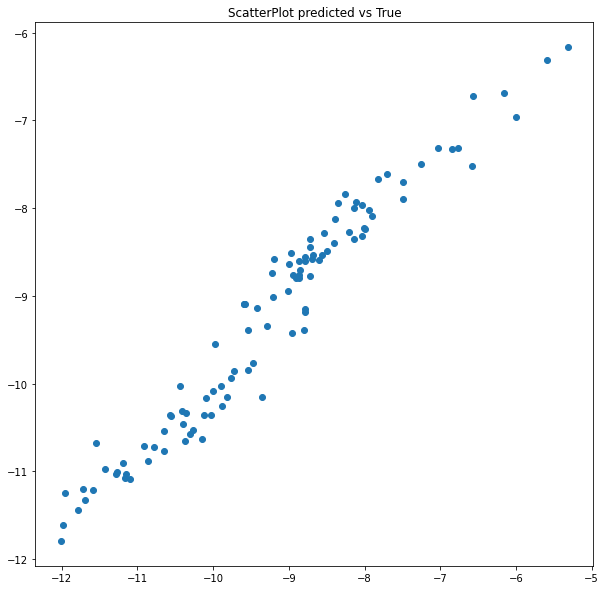

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05633
Feature:               commutersdensity, Score: 0.03051
Feature:                         depriv, Score: 0.05536
Feature:                            lat, Score: 0.69039
Feature:                 Ratio0200ver65, Score: 0.08086
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00779
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00655
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00989
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03030
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.01781
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.00864
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00557


<Figure size 432x288 with 0 Axes>

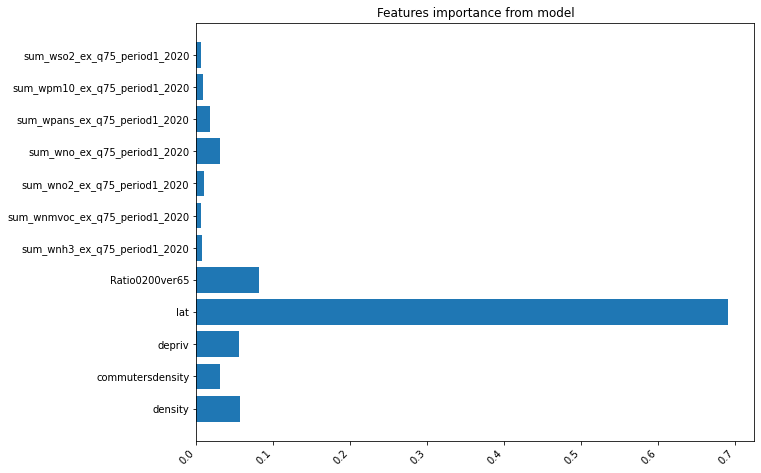

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.10316
Feature:               commutersdensity, Score: 0.06981
Feature:                         depriv, Score: 0.14289
Feature:                            lat, Score: 3.09937
Feature:                 Ratio0200ver65, Score: 0.23629
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01765
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01491
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.03520
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.07532
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04961
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02233
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01128


<Figure size 432x288 with 0 Axes>

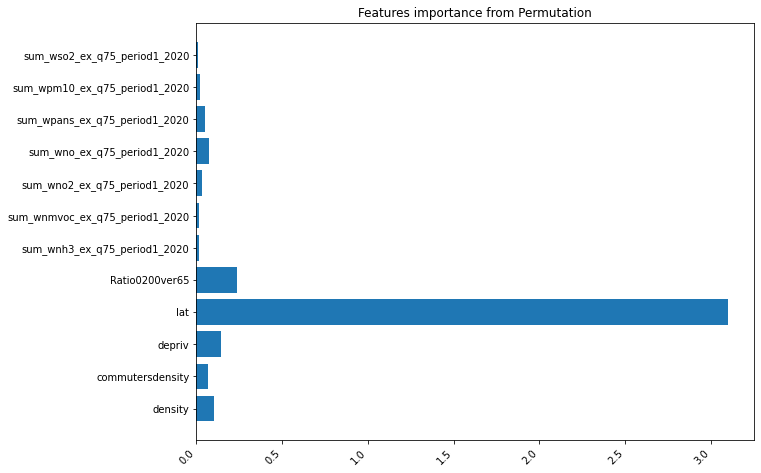

<Figure size 720x720 with 0 Axes>

((0.35879118393038156, 0.02410494771605411),
 (0.9415598345782001, 0.09292332048660819),
 0.3549353919745513,
 {'density': 0.02660147728671923,
  'commutersdensity': 0.0180014246717082,
  'depriv': 0.03684722356291245,
  'lat': 0.7992581403004597,
  'Ratio0200ver65': 0.06093477893673179,
  'sum_wnh3_ex_q75_period1_2020': 0.004550578790578781,
  'sum_wnmvoc_ex_q75_period1_2020': 0.0038440977974914096,
  'sum_wno2_ex_q75_period1_2020': 0.009077729798213988,
  'sum_wno_ex_q75_period1_2020': 0.019423422551199433,
  'sum_wpans_ex_q75_period1_2020': 0.012792164556411864,
  'sum_wpm10_ex_q75_period1_2020': 0.005759548627137556,
  'sum_wso2_ex_q75_period1_2020': 0.0029094131204356337})

<Figure size 432x288 with 0 Axes>

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_allfeatures", pout=sys.stdout, showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.12597913247612838
2  of  1200 MSE:  0.11624874201586485
3  of  1200 MSE:  0.20036726691923124
4  of  1200 MSE:  0.27476294390088046
5  of  1200 MSE:  0.44273179036183347
6  of  1200 MSE:  0.5592781184774022
7  of  1200 MSE:  0.6205903247992808
8  of  1200 MSE:  0.7027387078552803
9  of  1200 MSE:  0.2018427204885742
10  of  1200 MSE:  0.23738720848086964
11  of  1200 MSE:  0.23363658827785116
12  of  1200 MSE:  0.30757384991402714
13  of  1200 MSE:  0.44273179036183347
14  of  1200 MSE:  0.5592781184774022
15  of  1200 MSE:  0.6205903247992808
16  of  1200 MSE:  0.7027387078552803
17  of  1200 MSE:  0.35144094322066227
18  of  1200 MSE:  0.42467313833404935
19  of  1200 MSE:  0.37166830418945984
20  of  1200 MSE:  0.45891217073474405
21  of  1200 MSE:  0.44273179036183347
22  of  1200 MSE:  0.5592781184774022
23  of  1200 MSE:  0.6205903247992808
24  of  1200 MSE:  0.7027387078552803
25  of  1200 MSE:  0.45637643581131837
26  of  1200 MSE:  0.5466121261664512
27  of

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'random_state': 1}
Training set average RMSE:  0.35402  0.01673 
    Test set average RMSE:  0.93198  0.07913 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33902
                       R2:  0.94740


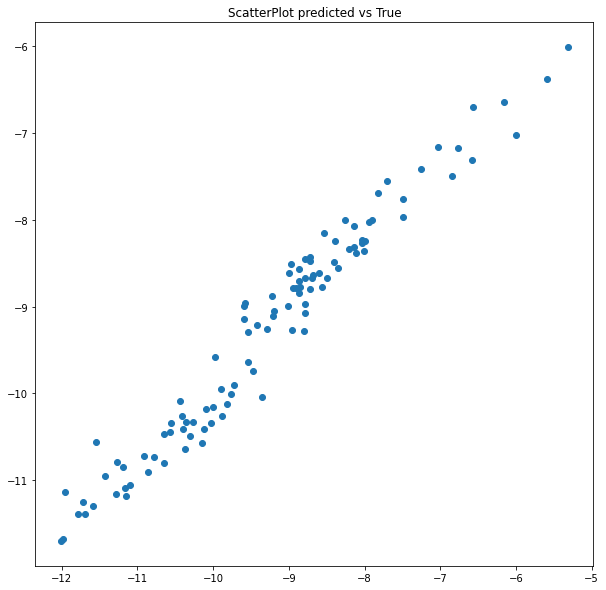

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05546
Feature:               commutersdensity, Score: 0.17873
Feature:                         depriv, Score: 0.11115
Feature:                            lat, Score: 0.25427
Feature:                 Ratio0200ver65, Score: 0.07719
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.06746
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.06345
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.09225
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01559
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02259
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03903
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02283


<Figure size 432x288 with 0 Axes>

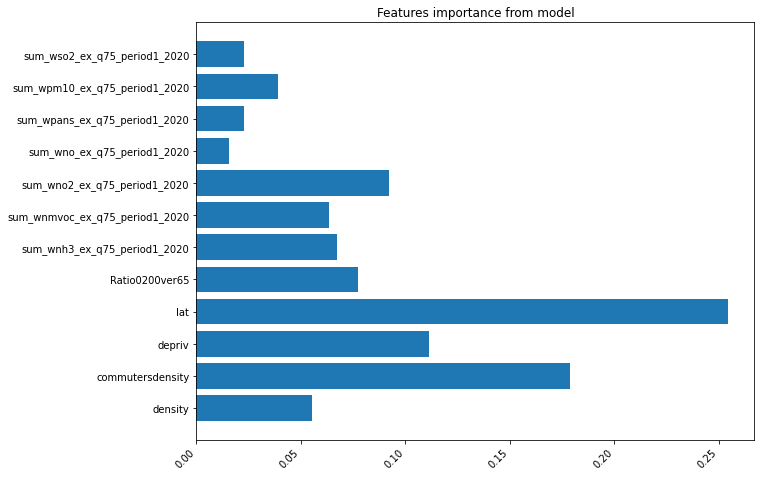

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.10951
Feature:               commutersdensity, Score: 0.06215
Feature:                         depriv, Score: 0.14334
Feature:                            lat, Score: 3.22036
Feature:                 Ratio0200ver65, Score: 0.20188
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.03515
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01209
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.02865
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05268
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04378
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01934
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01813


<Figure size 432x288 with 0 Axes>

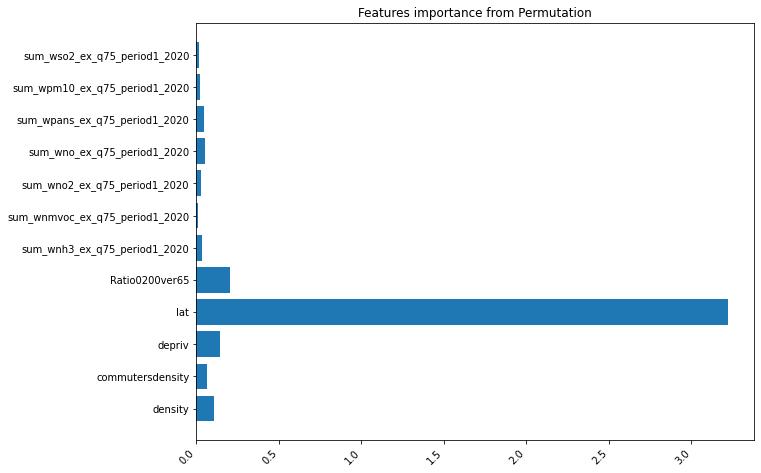

<Figure size 720x720 with 0 Axes>

((0.3540190752359319, 0.0167323345119214),
 (0.9319825074029577, 0.0791261207521372),
 0.3390215266575721,
 {'density': 0.027743487878065267,
  'commutersdensity': 0.015744890279181786,
  'depriv': 0.036316163856111444,
  'lat': 0.8158887116250592,
  'Ratio0200ver65': 0.051145832540273016,
  'sum_wnh3_ex_q75_period1_2020': 0.008906256921185796,
  'sum_wnmvoc_ex_q75_period1_2020': 0.003063707826398873,
  'sum_wno2_ex_q75_period1_2020': 0.007258759321948764,
  'sum_wno_ex_q75_period1_2020': 0.013345882679496684,
  'sum_wpans_ex_q75_period1_2020': 0.011091915516658588,
  'sum_wpm10_ex_q75_period1_2020': 0.004900686825727498,
  'sum_wso2_ex_q75_period1_2020': 0.00459370472989314})

<Figure size 432x288 with 0 Axes>

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt",showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38952  0.02976 
    Test set average RMSE:  1.03287  0.13407 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36576
                       R2:  0.93878


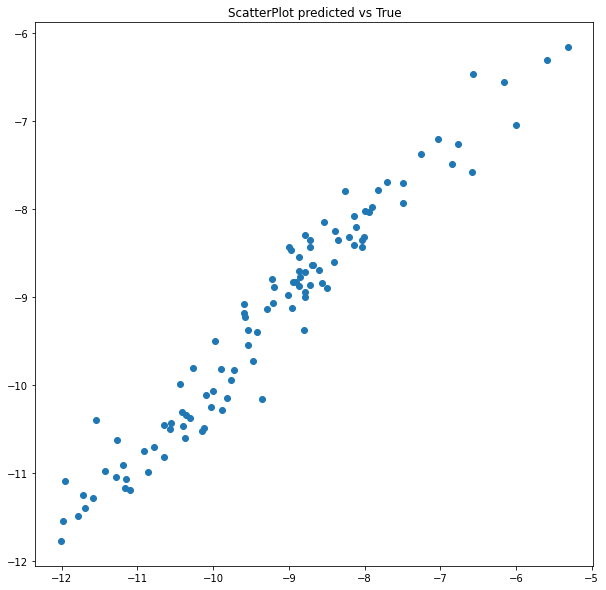

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.08325
Feature:               commutersdensity, Score: 0.52483
Feature:                         depriv, Score: 0.07309
Feature:                 Ratio0200ver65, Score: 0.14348
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02507
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.02125
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.03515
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03335
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02295
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01930
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01827


<Figure size 432x288 with 0 Axes>

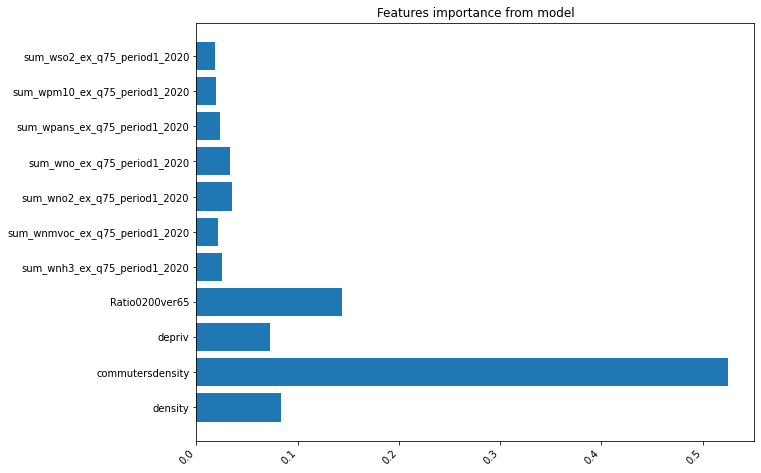

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.15704
Feature:               commutersdensity, Score: 1.97073
Feature:                         depriv, Score: 0.26299
Feature:                 Ratio0200ver65, Score: 0.36653
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.04258
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.04602
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.08570
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05095
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04945
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.05833
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04351


<Figure size 432x288 with 0 Axes>

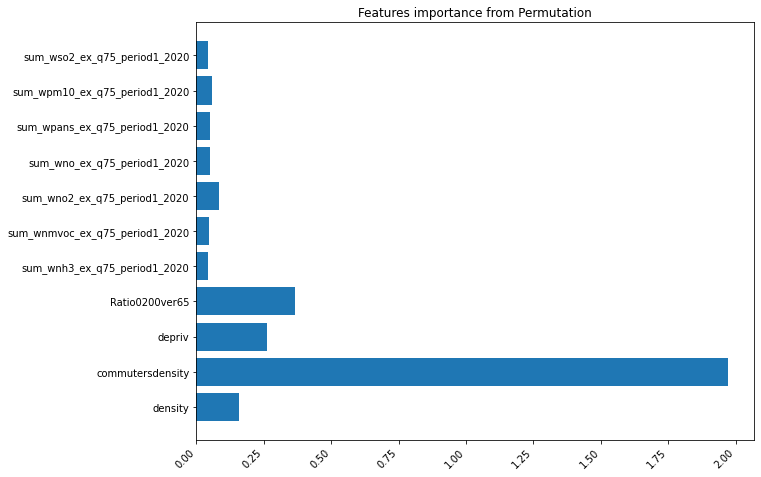

<Figure size 720x720 with 0 Axes>

((0.38951694926715696, 0.029758428110939955),
 (1.0328745662236074, 0.13406954554468434),
 0.3657623774627651,
 {'density': 0.05011020604892514,
  'commutersdensity': 0.628854891943072,
  'depriv': 0.08392039834896681,
  'Ratio0200ver65': 0.11695988019271435,
  'sum_wnh3_ex_q75_period1_2020': 0.013588533475811774,
  'sum_wnmvoc_ex_q75_period1_2020': 0.014684007181952041,
  'sum_wno2_ex_q75_period1_2020': 0.027346797371685348,
  'sum_wno_ex_q75_period1_2020': 0.01625865293387467,
  'sum_wpans_ex_q75_period1_2020': 0.01578043240044166,
  'sum_wpm10_ex_q75_period1_2020': 0.018613812674783112,
  'sum_wso2_ex_q75_period1_2020': 0.013882387427773134})

<Figure size 432x288 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.13378211676721424
2  of  1200 MSE:  0.12182535848799149
3  of  1200 MSE:  0.24265083269502513
4  of  1200 MSE:  0.33085129018237464
5  of  1200 MSE:  0.5324254544436247
6  of  1200 MSE:  0.66080033013271
7  of  1200 MSE:  0.7740460716222279
8  of  1200 MSE:  0.8242046380239721
9  of  1200 MSE:  0.21851510778094335
10  of  1200 MSE:  0.2804600287784167
11  of  1200 MSE:  0.2738830183224865
12  of  1200 MSE:  0.3580931544268765
13  of  1200 MSE:  0.5324254544436247
14  of  1200 MSE:  0.66080033013271
15  of  1200 MSE:  0.7740460716222279
16  of  1200 MSE:  0.8242046380239721
17  of  1200 MSE:  0.3971724884448277
18  of  1200 MSE:  0.4854881713035736
19  of  1200 MSE:  0.4374764739007061
20  of  1200 MSE:  0.5260875723305278
21  of  1200 MSE:  0.5324254544436247
22  of  1200 MSE:  0.66080033013271
23  of  1200 MSE:  0.7740460716222279
24  of  1200 MSE:  0.8242046380239721
25  of  1200 MSE:  0.5176108891512239
26  of  1200 MSE:  0.6147854124416501
27  of  1200 MSE:  0.5

Training set average RMSE:  0.36751  0.02654 
    Test set average RMSE:  1.01333  0.12423 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34830
                       R2:  0.94449


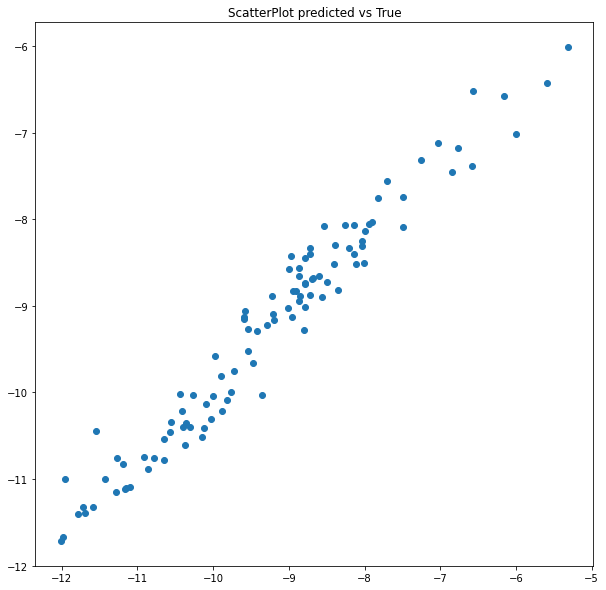

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07804
Feature:               commutersdensity, Score: 0.24065
Feature:                         depriv, Score: 0.14831
Feature:                 Ratio0200ver65, Score: 0.10289
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.08899
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09493
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.10619
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01840
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03000
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.05977
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03181


<Figure size 432x288 with 0 Axes>

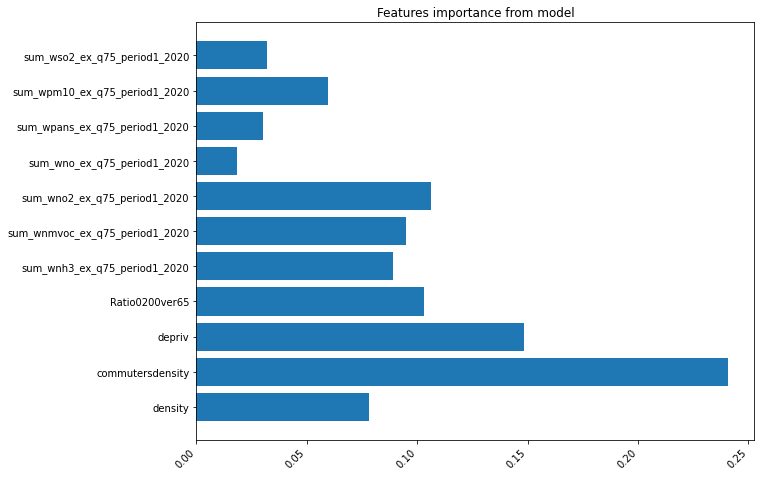

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.15855
Feature:               commutersdensity, Score: 1.75301
Feature:                         depriv, Score: 0.24850
Feature:                 Ratio0200ver65, Score: 0.35781
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.06579
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.06212
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.08670
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05560
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04355
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04089
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03639


<Figure size 432x288 with 0 Axes>

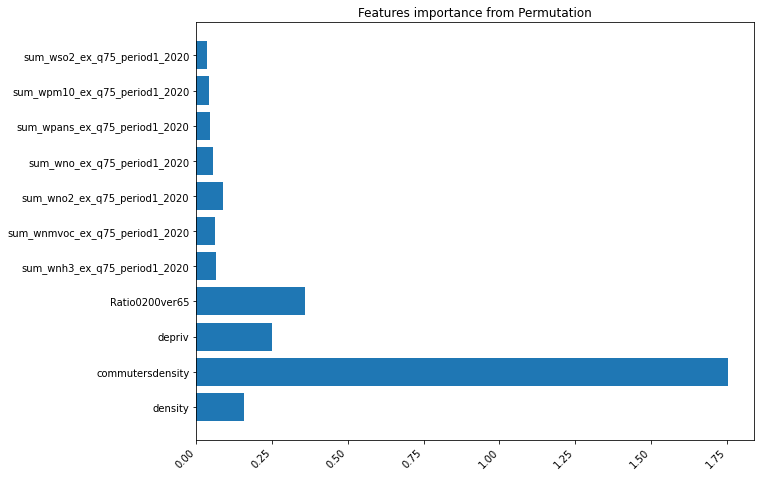

<Figure size 720x720 with 0 Axes>

((0.3675102783845516, 0.026536879936006855),
 (1.0133255605644855, 0.12423190853106002),
 0.34830178224603975,
 {'density': 0.054505565992560116,
  'commutersdensity': 0.6026340478268111,
  'depriv': 0.08542743497152087,
  'Ratio0200ver65': 0.12300465272439867,
  'sum_wnh3_ex_q75_period1_2020': 0.022617613798793828,
  'sum_wnmvoc_ex_q75_period1_2020': 0.02135341508904499,
  'sum_wno2_ex_q75_period1_2020': 0.02980322453910813,
  'sum_wno_ex_q75_period1_2020': 0.01911458410422859,
  'sum_wpans_ex_q75_period1_2020': 0.014970228557108698,
  'sum_wpm10_ex_q75_period1_2020': 0.014058201510372991,
  'sum_wso2_ex_q75_period1_2020': 0.012511030886052005})

<Figure size 432x288 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.40046  0.02902 
    Test set average RMSE:  1.08333  0.12153 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37116
                       R2:  0.93696


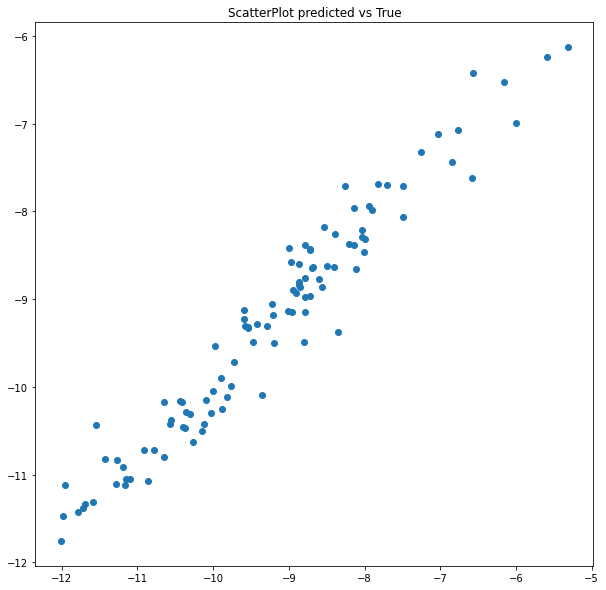

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.10153
Feature:                         depriv, Score: 0.21551
Feature:                 Ratio0200ver65, Score: 0.14390
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.15990
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09488
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.18566
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01925
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02364
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02866
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02706


<Figure size 432x288 with 0 Axes>

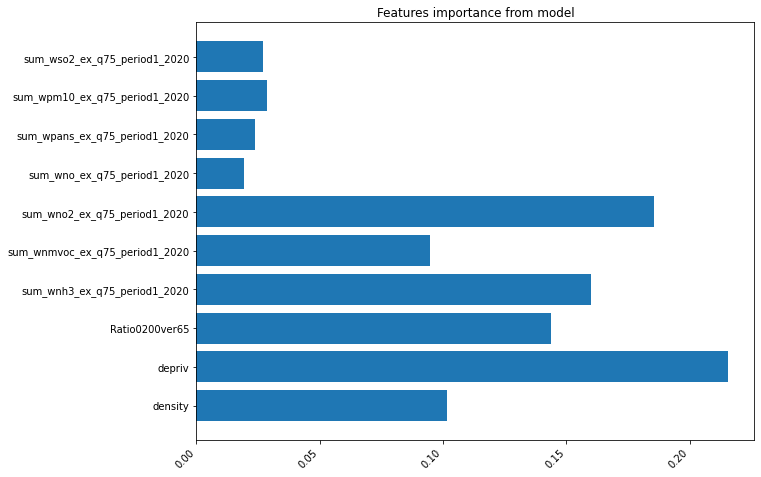

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.20113
Feature:                         depriv, Score: 0.45405
Feature:                 Ratio0200ver65, Score: 0.33932
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.34065
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.12531
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.50631
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.04225
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06024
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04155
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.08602


<Figure size 432x288 with 0 Axes>

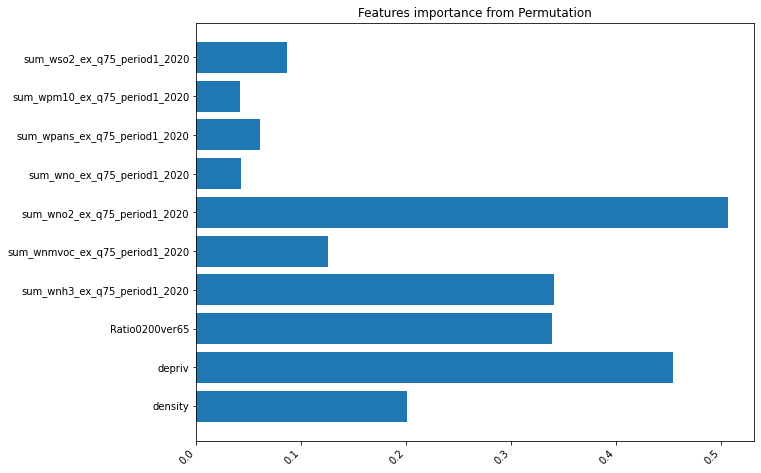

<Figure size 720x720 with 0 Axes>

((0.4004613532893494, 0.029023076856501157),
 (1.0833277884976642, 0.12152814193142775),
 0.37116095894390055,
 {'density': 0.09155418943289748,
  'depriv': 0.20668379332073378,
  'Ratio0200ver65': 0.1544602213659381,
  'sum_wnh3_ex_q75_period1_2020': 0.15506430207076277,
  'sum_wnmvoc_ex_q75_period1_2020': 0.057043015904489874,
  'sum_wno2_ex_q75_period1_2020': 0.23047003051998174,
  'sum_wno_ex_q75_period1_2020': 0.019234219206343325,
  'sum_wpans_ex_q75_period1_2020': 0.027420196657749748,
  'sum_wpm10_ex_q75_period1_2020': 0.018912902675688865,
  'sum_wso2_ex_q75_period1_2020': 0.039157128845414294})

<Figure size 432x288 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocom", pout=sys.stdout, showplot=True)

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.13776045744415583
2  of  1200 MSE:  0.1296097721151074
3  of  1200 MSE:  0.26067866207543794
4  of  1200 MSE:  0.36272319621147536
5  of  1200 MSE:  0.5778896150872135
6  of  1200 MSE:  0.6977316681843043
7  of  1200 MSE:  0.8259370330568452
8  of  1200 MSE:  0.8851054093733693
9  of  1200 MSE:  0.2294760546413759
10  of  1200 MSE:  0.2940064808881419
11  of  1200 MSE:  0.29587924490080836
12  of  1200 MSE:  0.39867113439281365
13  of  1200 MSE:  0.5778896150872135
14  of  1200 MSE:  0.6977316681843043
15  of  1200 MSE:  0.8259370330568452
16  of  1200 MSE:  0.8851054093733693
17  of  1200 MSE:  0.4035222750705177
18  of  1200 MSE:  0.5254861768617537
19  of  1200 MSE:  0.45372898785219434
20  of  1200 MSE:  0.5684282520268981
21  of  1200 MSE:  0.5778896150872135
22  of  1200 MSE:  0.6977316681843043
23  of  1200 MSE:  0.8259370330568452
24  of  1200 MSE:  0.8851054093733693
25  of  1200 MSE:  0.5398289358472053
26  of  1200 MSE:  0.6553690642420424
27  of  1200 MS

Training set average RMSE:  0.39056  0.02975 
    Test set average RMSE:  1.02227  0.13174 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36001
                       R2:  0.94069


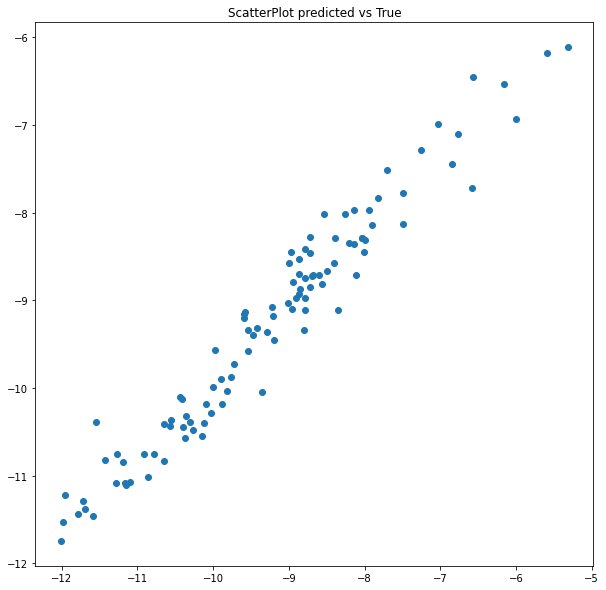

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.11133
Feature:                         depriv, Score: 0.20571
Feature:                 Ratio0200ver65, Score: 0.13409
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.10440
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.08867
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.16863
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01990
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03404
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.10004
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03320


<Figure size 432x288 with 0 Axes>

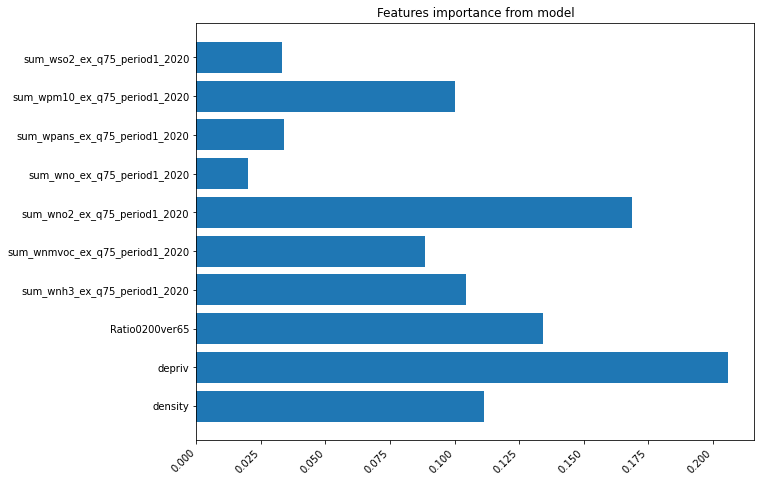

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.20698
Feature:                         depriv, Score: 0.44234
Feature:                 Ratio0200ver65, Score: 0.34269
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.41583
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09971
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.54003
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03383
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06031
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04839
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.08969


<Figure size 432x288 with 0 Axes>

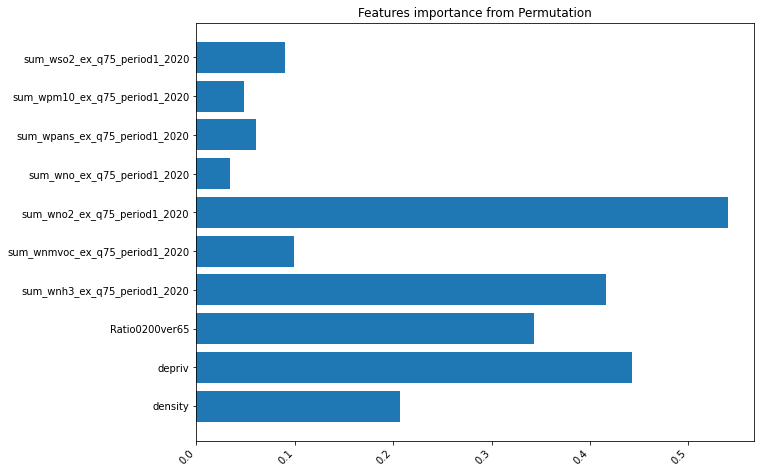

<Figure size 720x720 with 0 Axes>

((0.3905638089802169, 0.029751303026139722),
 (1.0222696044377637, 0.13173932509546027),
 0.3600135721262567,
 {'density': 0.09078806368778822,
  'depriv': 0.19402439670594274,
  'Ratio0200ver65': 0.15031640126012352,
  'sum_wnh3_ex_q75_period1_2020': 0.1823994827748847,
  'sum_wnmvoc_ex_q75_period1_2020': 0.04373516753128979,
  'sum_wno2_ex_q75_period1_2020': 0.23687717423316682,
  'sum_wno_ex_q75_period1_2020': 0.014837624640608983,
  'sum_wpans_ex_q75_period1_2020': 0.026455668880213425,
  'sum_wpm10_ex_q75_period1_2020': 0.02122511167407835,
  'sum_wso2_ex_q75_period1_2020': 0.03934090861190328})

<Figure size 432x288 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocom_opt", showplot=True, optimisedparams=bestf)